# Load Libraries and Data

In [1]:
# Importing standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Natural language processing ---------
import nltk

# Stopwords
nltk.download('stopwords')
# Lemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Regex
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kreilgaard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kreilgaard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kreilgaard/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load data
df = pd.read_csv('labeled_data.csv')
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Explore the Data (Should be moved to a new file perhaps)

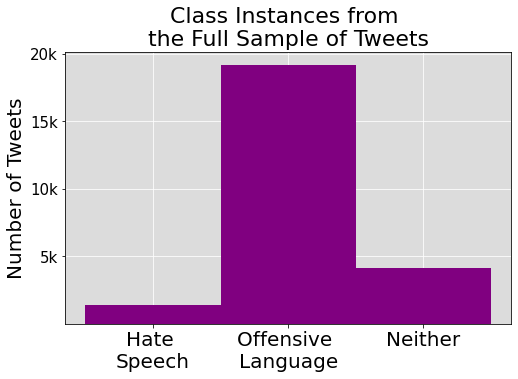

In [3]:
# Plot how many of each class we have
fig, ax = plt.subplots(figsize=(8,5))

ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Current sample
ax.hist(df['class'], bins=np.arange(-0.5,2.5+1, 1), color='purple', zorder=2)
plt.xticks([0,1,2], labels=['Hate \nSpeech', 'Offensive \nLanguage', 'Neither'], fontsize=20)
plt.yticks([5000, 10000, 15000, 20000],['5k','10k','15k','20k'], fontsize=15)
ax.set_ylabel('Number of Tweets', fontsize=20)

# Downsampling
# Make new plots of (if we chose) the tweets used we have equal amount of tweets for each class

ax.set_title('Class Instances from \nthe Full Sample of Tweets', fontsize=22)
plt.show()

# Cleaning/Counting Twitter Specific Characters

Overvej om du kan gøre noget smartere med emojis. Der er trods alt noget information i dem, måske kan de inddeles i følelser? Er der allerede et dictionary til det måske.

In [4]:
# Load stopwords that we want to remove
stopwords = nltk.corpus.stopwords.words("english")

# Add other stuff we want to remove, for example retweets rt
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

In [5]:
# Define a function that fixes twitter specific text
def tweet_yeet(string):
    """
    This function removes/changes (and counts) twitter specific stuff:
    - ampersands (&amp;) are replaced with 'and'
    - lots of whitespace with is replaced with one whitespace
    - URLs are replaced with URLHERE
    - mentions on the form @name are replaced with MENTIONHERE
    - emojis in HTML encoding (start = #& end = ;) are replaced with EMOTICONHERE
    
    It removes special characters, except ! and ?
    
    It also removes stopwords along with the twitter specifics we don't care about:
    - retweets (RT) are removed
    - follow friday (FF and #FF) are removed
    """
    
    # Exchange ampersands for 'and'
    parsed_string = re.sub('(&amp;)', 'and', string)
    
    # Exchange @username for MENTIONHERE (username can be alfanumeric and underscores)
    parsed_string = re.sub('@[\w\_]+', ' MENTIONHERE ', parsed_string)
    
    # Exchange emojis for EMOTICONHERE (MAYBE CHANGE LATER TO KEEP INFORMATION)
    parsed_string = re.sub('(&#\d+;)+', ' EMOTICONHERE ', parsed_string)
    
    # Exchange URLs for URLHERE (since URL look similar on twitter this is easier than usual)
    parsed_string = re.sub('https?:\/\/t\.co\/\w+', '', parsed_string)
    
    # Exchange ! for EXCLAMATIONMARK
    parsed_string = re.sub('\!+',' EXCLAMATIONMARK ', parsed_string)
    
    # Exchange ! for QUESTIONMARK
    parsed_string = re.sub('\?+',' QUESTIONMARK ', parsed_string)
    
    # Remove excess white space (+ removes one or more of the pattern)
    parsed_string = re.sub('\s+', ' ', parsed_string)
    
    # Remove all the special characters except ! and ? and replace with a whitespace
    parsed_string = re.sub("[^a-zA-Z!?']", " ", parsed_string) 
    
    # Convert all letters to lower case and split into words
    words = parsed_string.lower().split()

    # Remove stopwords, RT, FF and #FF
    words = [w for w in words if not w in stopwords]   
    
    # Join all words back to text
    parsed_text = " ".join(words)
    
    # Remove ' in case some are left that were not in stopwords
    parsed_text = re.sub("'", "", parsed_text)
    
    return parsed_text

In [6]:
# Use tweet yeet on entire dataframe and add a new column with cleaned tweets

# Array to store clean tweets
clean_tweets = []

# Loop over tweets
for i in range(len(df)):
    
    # Clean each tweet and append
    tweet = tweet_yeet(df['tweet'][i])
    clean_tweets.append(tweet)
    
# Add new column to existing dataframe
df['clean tweet'] = clean_tweets

# Converting Words to their Base Form (Lemmatization with POS)

Should one use stemming or lemmatization?
https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221

In [19]:
# Initialise the Wordnet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define the helper function that converts NLTKs tag into wordnet format
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    
    # Get NLTK tag
    tag = nltk.pos_tag([word])[0][1][0].upper()
    print(tag)
    # Dictionary that defines the conversion (for valied wordnet part of speech tags)
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    
    # Get wordnet tag, if not a tag in wordnet, don't stem it
    try: tag_wordnet = tag_dict[tag]
    except: tag_wordnet = nltk.corpus.wordnet.VERB

    # Not completely sure this part works
    return tag_dict.get(tag, tag_wordnet)

# Def a function that takes a string and returns the base form of its words
def wordnet_base(string):
    
    # Split the string into words
    words = string.split()

    # Stem the words
    base_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words] 

    # Put words together into a single string
    base_string = " ".join(base_words)
    
    return base_string

In [20]:
df['clean tweet'][7], wordnet_base(df['clean tweet'][7])

N
R
R
N
N
V
J
N
V
P
N
N
N
R


('exclamationmark emoticonhere mentionhere cause im tired big bitches coming us skinny girls exclamationmark emoticonhere',
 'exclamationmark emoticonhere mentionhere cause im tire big bitch come us skinny girl exclamationmark emoticonhere')

# Converting Words to their Base Form (PorterStemmer)

In [21]:
# Initialise the stemmer
stemmer = nltk.stem.PorterStemmer()

# Def a function that takes a string and returns the base form of its words
def porter_base(string):
    
    # Split the string into words
    words = string.split()

    # Stem the words
    base_words = [stemmer.stem(w) for w in words] 

    # Put words together into a single string
    base_string = " ".join(base_words)
    
    return base_string

In [22]:
df['clean tweet'][7], porter_base(df['clean tweet'][7])

('exclamationmark emoticonhere mentionhere cause im tired big bitches coming us skinny girls exclamationmark emoticonhere',
 'exclamationmark emoticonher mentionher caus im tire big bitch come us skinni girl exclamationmark emoticonher')

In [23]:
wordnet_base('ass')

N


'as'

## Test the stemming methods

In [11]:
porter_base('jumping jumper jump us you them his')

'jump jumper jump us you them hi'

In [12]:
wordnet_base('jumping jumper jump us you them his')

'jumping jumper jump us you them his'

The wordnet lemmatizer seems to be better at handling pronouns and not changing them to something wrong, as long as we use verb as default.

## Stem the tweets and add to dataframe

In [13]:
# Array to store stemmed tweets
stemmed_tweets = []

# Loop over tweets
for i in range(len(df)):
    
    # Clean each tweet and append
    tweet = wordnet_base(df['clean tweet'][i])
    stemmed_tweets.append(tweet)
    
# Add new column to existing dataframe
df['stemmed tweet'] = stemmed_tweets

In [14]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean tweet,stemmed tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,exclamationmark mentionhere woman complain cle...,exclamationmark mentionhere woman complain cle...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,exclamationmark mentionhere boy dats cold tyga...,exclamationmark mentionhere boy dat cold tyga ...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,exclamationmark mentionhere dawg exclamationma...,exclamationmark mentionhere dawg exclamationma...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,exclamationmark mentionhere mentionhere look l...,exclamationmark mentionhere mentionhere look l...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,exclamationmark mentionhere shit hear might tr...,exclamationmark mentionhere shit hear might tr...
...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous muthaf lie emoticonhere mentionhere menti...,yous muthaf lie emoticonhere mentionhere menti...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy,go broke wrong heart baby drove redneck crazy
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat exclamationmark dat niggu...,young buck wanna eat exclamationmark dat niggu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies,youu get wild bitch tellin lie


# Export Data to File

In [15]:
# Export data
df.to_csv('parsed_data.csv', index=False)